In [1]:
!git clone https://github.com/osmr/imgclsmob.git
!pip install -r /kaggle/working/imgclsmob/requirements.txt

Cloning into 'imgclsmob'...
remote: Enumerating objects: 30269, done.
remote: Counting objects: 100% (1509/1509), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 30269 (delta 1329), reused 1417 (delta 1329), pack-reused 28760
Receiving objects: 100% (30269/30269), 13.70 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (25791/25791), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/imgclsmob/requirements.txt'


In [2]:
from imgclsmob.pytorch.pytorchcv.models.cbamresnet import *

In [3]:
!pip install timm torchinfo

In [4]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
from pathlib import Path
import concurrent.futures
from torch import nn, optim
from tabulate import tabulate
from torchinfo import summary
from datetime import timedelta
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from functools import partial, lru_cache
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from timm.models.vision_transformer import Block as transformer_block
from collections import defaultdict, Counter
from timm.models.registry import register_model
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
dataset = Path(r"/kaggle/input/") 
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset" 
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray" 
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database" 

In [8]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [9]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [10]:
class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 804828.07it/s]


In [15]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [16]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 17251
Total Validation Samples: 2465
Total Test Samples: 4929

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Normal                        1946                 278           556
Lung_Opacity                  2531                 362           723
Viral Pneumonia               4209                 601          1202
COVID                         7134                1019          2039
Bacterial Pneumonia            490                  70           140
Tuberculosis                   941                 135           269


In [17]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pil_img = Image.fromarray(img)

        transformed_img = self.transform(pil_img)  

        label = self.img_labels[index]
        return transformed_img, label
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [19]:
model = cbam_resnet152()
model.output = nn.Linear(model.output.in_features, num_classes)
model.to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
CbamResNet                                              [1, 6]                    --
├─Sequential: 1-1                                       [1, 2048, 1, 1]           --
│    └─ResInitBlock: 2-1                                [1, 64, 56, 56]           --
│    │    └─ConvBlock: 3-1                              [1, 64, 112, 112]         9,536
│    │    └─MaxPool2d: 3-2                              [1, 64, 56, 56]           --
│    └─Sequential: 2-2                                  [1, 256, 56, 56]          --
│    │    └─CbamResUnit: 3-3                            [1, 256, 56, 56]          83,572
│    │    └─CbamResUnit: 3-4                            [1, 256, 56, 56]          78,964
│    │    └─CbamResUnit: 3-5                            [1, 256, 56, 56]          78,964
│    └─Sequential: 2-3                                  [1, 512, 28, 28]          --
│    │    └─CbamResUnit: 3-6                 

In [20]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
total_epochs = 50
patience = 10
current_patience = 0
best_val_loss = float('inf')

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()

    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}")):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validation")):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    print(f"Epoch {epoch + 1}/{total_epochs}")
    print(f"Train - loss: {average_loss:.4f} - accuracy: {train_metrics['accuracy']:.4f} - precision: {train_metrics['precision']:.4f} - recall: {train_metrics['recall']:.4f} - f1_score: {train_metrics['f1_score']:.4f} - specificity: {train_metrics['specificity']:.4f} - sensitivity: {train_metrics['sensitivity']:.4f} - mcc: {train_metrics['mcc']:.4f} - auc: {train_metrics['auc']:.4f}")
    print(f"Val - loss: {average_loss:.4f} - accuracy: {val_metrics['accuracy']:.4f} - precision: {val_metrics['precision']:.4f} - recall: {val_metrics['recall']:.4f} - f1_score: {val_metrics['f1_score']:.4f} - specificity: {val_metrics['specificity']:.4f} - sensitivity: {val_metrics['sensitivity']:.4f} - mcc: {val_metrics['mcc']:.4f} - auc: {val_metrics['auc']:.4f}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
        val_metrics_history[metric_name].append(val_metrics[metric_name])

    if average_loss < best_val_loss:
        best_val_loss = average_loss
        current_patience = 0
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to lack of improvement in validation loss.")
        break

Validation: 100%|██████████| 155/155 [00:18<00:00,  8.57it/s]


Epoch 1/50
Train - loss: 0.5846 - accuracy: 0.7263 - precision: 0.7234 - recall: 0.7263 - f1_score: 0.7190 - specificity: 0.7405 - sensitivity: 0.9561 - mcc: 0.6186 - auc: 0.9296
Val - loss: 0.5846 - accuracy: 0.7753 - precision: 0.8014 - recall: 0.7753 - f1_score: 0.7718 - specificity: 0.6547 - sensitivity: 0.9872 - mcc: 0.6974 - auc: 0.9629


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.52it/s]


Epoch 2/50
Train - loss: 0.4059 - accuracy: 0.8281 - precision: 0.8253 - recall: 0.8281 - f1_score: 0.8254 - specificity: 0.8453 - sensitivity: 0.9670 - mcc: 0.7638 - auc: 0.9720
Val - loss: 0.4059 - accuracy: 0.8479 - precision: 0.8569 - recall: 0.8479 - f1_score: 0.8501 - specificity: 0.7482 - sensitivity: 0.9872 - mcc: 0.7937 - auc: 0.9800


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.56it/s]


Epoch 3/50
Train - loss: 0.3492 - accuracy: 0.8597 - precision: 0.8576 - recall: 0.8597 - f1_score: 0.8578 - specificity: 0.8525 - sensitivity: 0.9710 - mcc: 0.8074 - auc: 0.9805
Val - loss: 0.3492 - accuracy: 0.8682 - precision: 0.8674 - recall: 0.8682 - f1_score: 0.8657 - specificity: 0.8813 - sensitivity: 0.9767 - mcc: 0.8191 - auc: 0.9840


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 4/50
Train - loss: 0.4388 - accuracy: 0.8838 - precision: 0.8825 - recall: 0.8838 - f1_score: 0.8827 - specificity: 0.8582 - sensitivity: 0.9774 - mcc: 0.8407 - auc: 0.9862
Val - loss: 0.4388 - accuracy: 0.8410 - precision: 0.8454 - recall: 0.8410 - f1_score: 0.8405 - specificity: 0.8885 - sensitivity: 0.9657 - mcc: 0.7862 - auc: 0.9782


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.57it/s]


Epoch 5/50
Train - loss: 0.3241 - accuracy: 0.9020 - precision: 0.9013 - recall: 0.9020 - f1_score: 0.9014 - specificity: 0.8777 - sensitivity: 0.9810 - mcc: 0.8657 - auc: 0.9896
Val - loss: 0.3241 - accuracy: 0.8803 - precision: 0.8816 - recall: 0.8803 - f1_score: 0.8796 - specificity: 0.8849 - sensitivity: 0.9840 - mcc: 0.8352 - auc: 0.9871


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 6/50
Train - loss: 0.3106 - accuracy: 0.9142 - precision: 0.9138 - recall: 0.9142 - f1_score: 0.9139 - specificity: 0.8967 - sensitivity: 0.9847 - mcc: 0.8825 - auc: 0.9922
Val - loss: 0.3106 - accuracy: 0.8848 - precision: 0.8956 - recall: 0.8848 - f1_score: 0.8852 - specificity: 0.6727 - sensitivity: 0.9959 - mcc: 0.8436 - auc: 0.9879


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 7/50
Train - loss: 0.3310 - accuracy: 0.9306 - precision: 0.9304 - recall: 0.9306 - f1_score: 0.9304 - specificity: 0.9116 - sensitivity: 0.9887 - mcc: 0.9050 - auc: 0.9946
Val - loss: 0.3310 - accuracy: 0.8783 - precision: 0.8869 - recall: 0.8783 - f1_score: 0.8801 - specificity: 0.8381 - sensitivity: 0.9881 - mcc: 0.8369 - auc: 0.9889


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 8/50
Train - loss: 0.2924 - accuracy: 0.9376 - precision: 0.9375 - recall: 0.9376 - f1_score: 0.9375 - specificity: 0.9116 - sensitivity: 0.9894 - mcc: 0.9146 - auc: 0.9958
Val - loss: 0.2924 - accuracy: 0.8966 - precision: 0.8963 - recall: 0.8966 - f1_score: 0.8957 - specificity: 0.9317 - sensitivity: 0.9762 - mcc: 0.8587 - auc: 0.9895


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.57it/s]


Epoch 9/50
Train - loss: 0.2922 - accuracy: 0.9529 - precision: 0.9528 - recall: 0.9529 - f1_score: 0.9528 - specificity: 0.9450 - sensitivity: 0.9925 - mcc: 0.9355 - auc: 0.9971
Val - loss: 0.2922 - accuracy: 0.8978 - precision: 0.8980 - recall: 0.8978 - f1_score: 0.8973 - specificity: 0.9317 - sensitivity: 0.9817 - mcc: 0.8600 - auc: 0.9899


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.60it/s]


Epoch 11/50
Train - loss: 0.3919 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - f1_score: 0.9666 - specificity: 0.9599 - sensitivity: 0.9947 - mcc: 0.9543 - auc: 0.9987
Val - loss: 0.3919 - accuracy: 0.8734 - precision: 0.8796 - recall: 0.8734 - f1_score: 0.8729 - specificity: 0.8058 - sensitivity: 0.9936 - mcc: 0.8277 - auc: 0.9871


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 12/50
Train - loss: 0.3588 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - f1_score: 0.9722 - specificity: 0.9743 - sensitivity: 0.9965 - mcc: 0.9620 - auc: 0.9990
Val - loss: 0.3588 - accuracy: 0.8937 - precision: 0.8951 - recall: 0.8937 - f1_score: 0.8933 - specificity: 0.8741 - sensitivity: 0.9872 - mcc: 0.8554 - auc: 0.9887


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.56it/s]


Epoch 13/50
Train - loss: 0.4061 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - f1_score: 0.9763 - specificity: 0.9743 - sensitivity: 0.9957 - mcc: 0.9677 - auc: 0.9993
Val - loss: 0.4061 - accuracy: 0.8803 - precision: 0.8858 - recall: 0.8803 - f1_score: 0.8808 - specificity: 0.7734 - sensitivity: 0.9936 - mcc: 0.8373 - auc: 0.9870


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.57it/s]


Epoch 14/50
Train - loss: 0.4056 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - f1_score: 0.9770 - specificity: 0.9728 - sensitivity: 0.9969 - mcc: 0.9686 - auc: 0.9993
Val - loss: 0.4056 - accuracy: 0.8860 - precision: 0.8884 - recall: 0.8860 - f1_score: 0.8864 - specificity: 0.8957 - sensitivity: 0.9835 - mcc: 0.8462 - auc: 0.9884


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.56it/s]


Epoch 15/50
Train - loss: 0.3988 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - f1_score: 0.9809 - specificity: 0.9815 - sensitivity: 0.9975 - mcc: 0.9738 - auc: 0.9994
Val - loss: 0.3988 - accuracy: 0.8888 - precision: 0.8954 - recall: 0.8888 - f1_score: 0.8900 - specificity: 0.7770 - sensitivity: 0.9936 - mcc: 0.8494 - auc: 0.9881


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.59it/s]


Epoch 16/50
Train - loss: 0.5119 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - f1_score: 0.9818 - specificity: 0.9794 - sensitivity: 0.9974 - mcc: 0.9751 - auc: 0.9995
Val - loss: 0.5119 - accuracy: 0.8722 - precision: 0.8816 - recall: 0.8722 - f1_score: 0.8692 - specificity: 0.8417 - sensitivity: 0.9909 - mcc: 0.8284 - auc: 0.9865


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.57it/s]


Epoch 17/50
Train - loss: 0.4164 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - f1_score: 0.9823 - specificity: 0.9810 - sensitivity: 0.9977 - mcc: 0.9758 - auc: 0.9996
Val - loss: 0.4164 - accuracy: 0.8901 - precision: 0.8922 - recall: 0.8901 - f1_score: 0.8903 - specificity: 0.8993 - sensitivity: 0.9890 - mcc: 0.8498 - auc: 0.9864


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.54it/s]


Epoch 18/50
Train - loss: 0.4804 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - f1_score: 0.9828 - specificity: 0.9800 - sensitivity: 0.9972 - mcc: 0.9765 - auc: 0.9996
Val - loss: 0.4804 - accuracy: 0.8795 - precision: 0.8845 - recall: 0.8795 - f1_score: 0.8803 - specificity: 0.7986 - sensitivity: 0.9931 - mcc: 0.8364 - auc: 0.9862


Validation: 100%|██████████| 155/155 [00:18<00:00,  8.60it/s]

Epoch 19/50
Train - loss: 0.5694 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - f1_score: 0.9846 - specificity: 0.9820 - sensitivity: 0.9980 - mcc: 0.9790 - auc: 0.9997
Val - loss: 0.5694 - accuracy: 0.8824 - precision: 0.8850 - recall: 0.8824 - f1_score: 0.8787 - specificity: 0.8633 - sensitivity: 0.9817 - mcc: 0.8389 - auc: 0.9844
Early stopping at epoch 19 due to lack of improvement in validation loss.


In [23]:
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

Total Training Time: 1:54:12.742078
Total Validation Time: 0:05:43.590673


In [24]:
avg_training_time_per_epoch = total_training_time / (epoch + 1)  
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)  
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Average Training Time per Epoch: 0:06:00.670636
Average Validation Time per Epoch: 0:00:18.083720


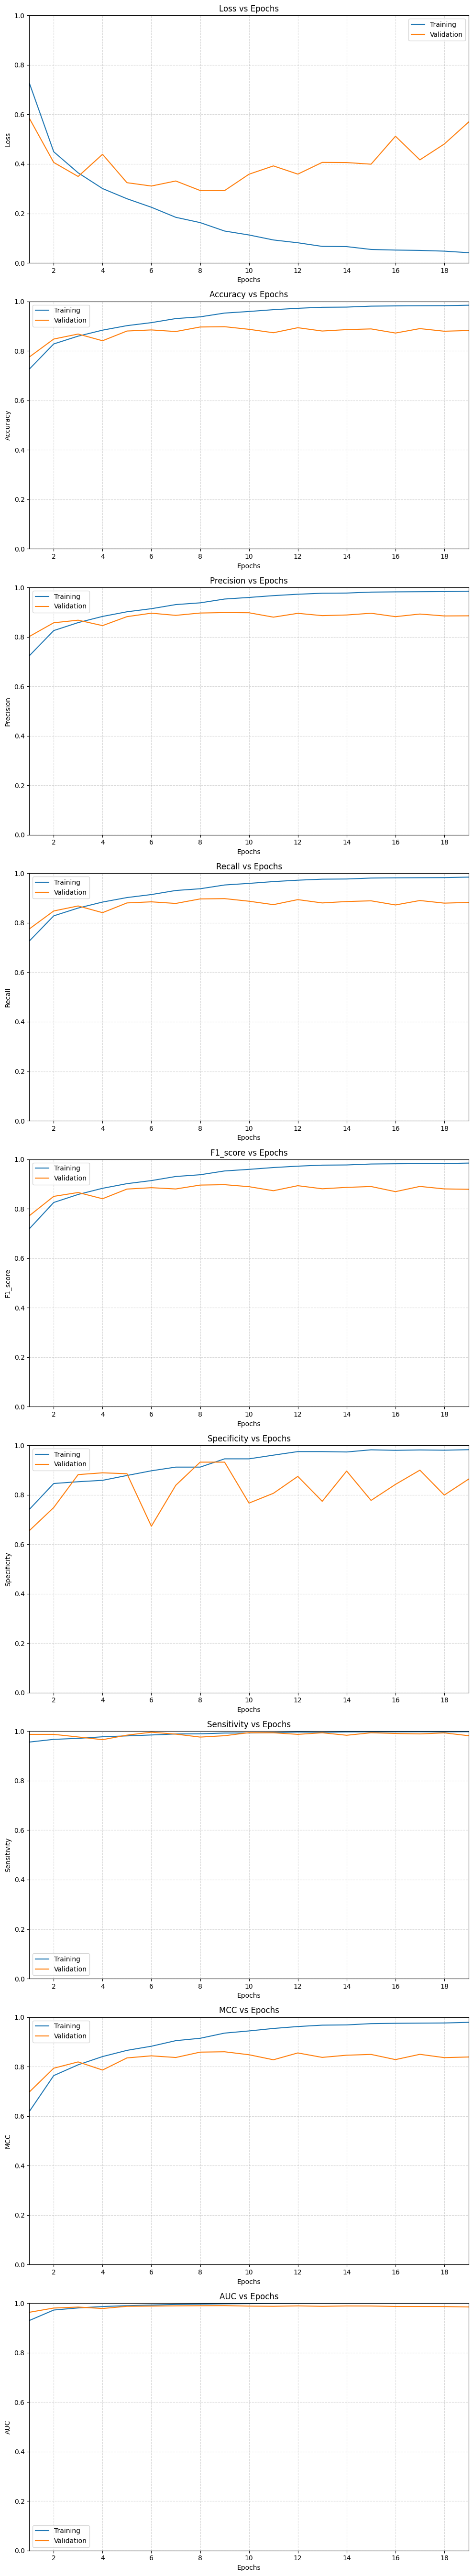

In [25]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [26]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 309/309 [00:35<00:00,  8.64it/s]

Metrics - loss: 0.5209, accuracy: 0.8941, precision: 0.8966, recall: 0.8941, f1_score: 0.8901, specificity: 0.8777, sensitivity: 0.9803, mcc: 0.8549, auc: 0.9833


In [28]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.8502    0.8777    0.8637       556
              COVID     0.9687    0.9419    0.9551       723
       Lung_Opacity     0.9245    0.8353    0.8776      1202
             Normal     0.8630    0.9671    0.9121      2039
       Tuberculosis     0.9854    0.9643    0.9747       140
    Viral Pneumonia     0.8819    0.4721    0.6150       269

           accuracy                         0.8941      4929
          macro avg     0.9123    0.8431    0.8664      4929
       weighted avg     0.8966    0.8941    0.8901      4929

There were 522 errors in 4929 tests for an accuracy of  89.41


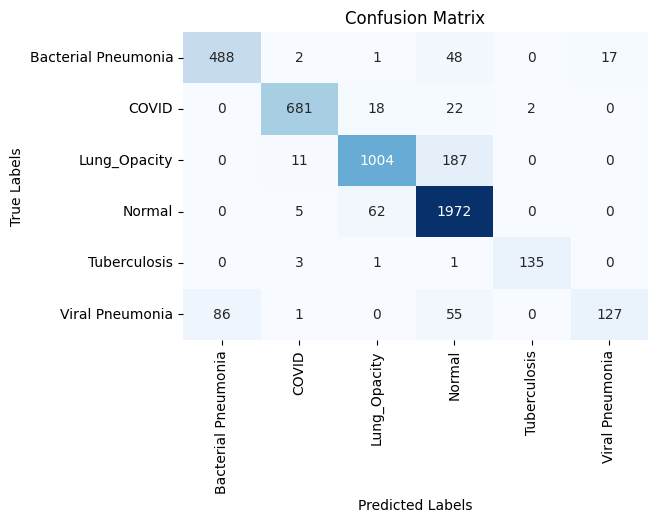

In [29]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()